In [1]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../common')
import common_probs
from sampler import DepthSampler
sys.path.append('../experimental')
from signature_size_model import SignatureSizeModel

# Designing a New Size Model Based on Signatures

Recall that I had before defined the signature of a state to be the depths that the failure chain visits. e.g. (0, 1, 3) the failure would go to 3, then 1, then 0. I also had an argument for why each signature in a depth corresponded to a unique state. What I realized was also the case is that if $j$ appears in a signature, this means that $j - 1$ must necessarily appear in the parent's signatures. Why is this? We can think of the substrings that match with the prefix in the $n$ length generalized string so that we already know their position and length. Then as we read in more the generalized string we encounter these substrings. Let's say we see a substring of length 4, that means in the last iteration we had only seen 3 characters out of that string.

This seems to lend itself well to some stochastic process in which we either add one to elements in the signature or discard the entry. Below I tested whether this model accurately describes the size of depths in expectation.

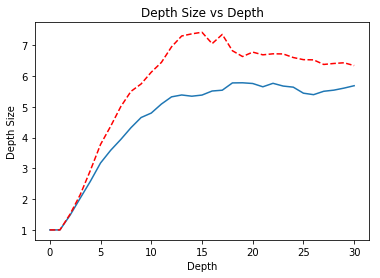

In [4]:
PROBS = [0.5 for _ in range(4)]
LENGTH = 30
SIMS = 1000

depths = range(LENGTH + 1)

# Get simulated average depth.
ds = DepthSampler(PROBS, LENGTH)
df = ds.draw_samples(SIMS, ['states'])
sim_avgs = df.groupby('depth').mean()

# Get the average depth size of the signature model.
ssm = SignatureSizeModel(PROBS, LENGTH)
sig_avgs = ssm.get_average_depth_sizes(SIMS)

# Plot
plt.plot(depths, sig_avgs)
plt.plot(depths, sim_avgs, '--r', label='Simulated Averages')
plt.xlabel('Depth')
plt.ylabel('Depth Size')
plt.title('Depth Size vs Depth')
plt.show()

This model seems to be an upper bound to the actual simulation. This is probably due to the fact that we do not consider dependencies between strings. That is, whenever we see if two letter sets match, two new sets are generated. However, this is still a pretty tight upper bound so if we could find the things for this model it would still be good. Would also need to prove that this model is an upper bound though, which could be tough.

# Attempting to Analytically Describe Model.

Let $Z_n$ be the number of states at depth $n$ and $\Lambda_n$ be the set of state signatures at depth $n$. Let $Y_{\lambda, n}$ be the offspring the state with signature $\lambda$ has. Finally, let $X_n$ be the number of states from different parents that were merged at depth $n$. Then we have,

$$
Z_{n + 1} = \sum_{\lambda \in \Lambda_n} Y_{\lambda, n} - X_{n + 1}
$$

Assuming things about independence...

$$
E[Z_{n + 1}] = E[Z_n] \sum_{\lambda} E[Y_{\lambda, n}] P(\lambda) - E[X_{n + 1}]
$$

One of the hardest parts of this seems to be finding $P(\lambda)$. However, I think this could be done with a Markov chain. Consider the chain with states labelled $0$ to $n$ (the length of the generalized string). $M$ is the ptm where $m_{i, j} = c_2^{j} (1 - c_2)^{i - j + 1}$ for $0 \leq j \leq i + 1$. This ptm assumes that all substrings are independent which is certainly not the case. However, making this assumption should be an upper bound since we are alleviating requirements that any one set of letters must fulfill (maybe???). The probability of  seeing $\lambda$ at depth $n$ is then $(M^n)_{0, j}$.